In [73]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#build model file
import joblib

# Ignore warnings
import warnings

warnings.filterwarnings('ignore')

plt.style.use("seaborn-v0_8-pastel")

sns.set_theme(
    style="whitegrid",
    palette="pastel",
    context="notebook"
)

In [74]:
df = pd.read_csv("customer_subscription_churn_usage_patterns.csv")

In [75]:
df.head()

,user_id,signup_date,plan_type,monthly_fee,avg_weekly_usage_hours,support_tickets,payment_failures,tenure_months,last_login_days_ago,churn
0,1,2023-04-15,Premium,699,1.1,4,1,8,14,Yes
1,2,2023-08-27,Premium,699,2.6,6,0,35,1,Yes
2,3,2023-10-12,Premium,699,14.3,8,3,2,14,Yes
3,4,2023-12-11,Basic,199,17.6,5,2,11,9,Yes
4,5,2023-02-14,Basic,199,9.8,5,2,6,38,Yes


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 2800 non-null   int64  
 1   signup_date             2800 non-null   object 
 2   plan_type               2800 non-null   object 
 3   monthly_fee             2800 non-null   int64  
 4   avg_weekly_usage_hours  2800 non-null   float64
 5   support_tickets         2800 non-null   int64  
 6   payment_failures        2800 non-null   int64  
 7   tenure_months           2800 non-null   int64  
 8   last_login_days_ago     2800 non-null   int64  
 9   churn                   2800 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 218.9+ KB


In [77]:
df.isnull().sum()

user_id                   0
signup_date               0
plan_type                 0
monthly_fee               0
avg_weekly_usage_hours    0
support_tickets           0
payment_failures          0
tenure_months             0
last_login_days_ago       0
churn                     0
dtype: int64

In [78]:
#drop userID
df.drop("user_id", axis=1, inplace=True)

In [79]:
#encode churn
df["churn"] = df["churn"].map({"Yes":1,"No":0})

In [80]:
#convert signup_date to datetime
df["signup_date"] = pd.to_datetime(df["signup_date"])

In [81]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

In [82]:
correlation = df[num_cols].corr()
correlation

,monthly_fee,avg_weekly_usage_hours,support_tickets,payment_failures,tenure_months,last_login_days_ago,churn
monthly_fee,1.000000,-0.030243,0.015366,-0.017959,0.014545,-0.003025,0.003796
avg_weekly_usage_hours,-0.030243,1.000000,0.030636,0.013552,-0.010306,-0.002434,-0.103788
support_tickets,0.015366,0.030636,1.000000,-0.007259,-0.044547,-0.058878,0.149623
payment_failures,-0.017959,0.013552,-0.007259,1.000000,0.022843,0.021437,0.213752
tenure_months,0.014545,-0.010306,-0.044547,0.022843,1.000000,0.017535,0.002044
last_login_days_ago,-0.003025,-0.002434,-0.058878,0.021437,0.017535,1.000000,0.186366
churn,0.003796,-0.103788,0.149623,0.213752,0.002044,0.186366,1.000000


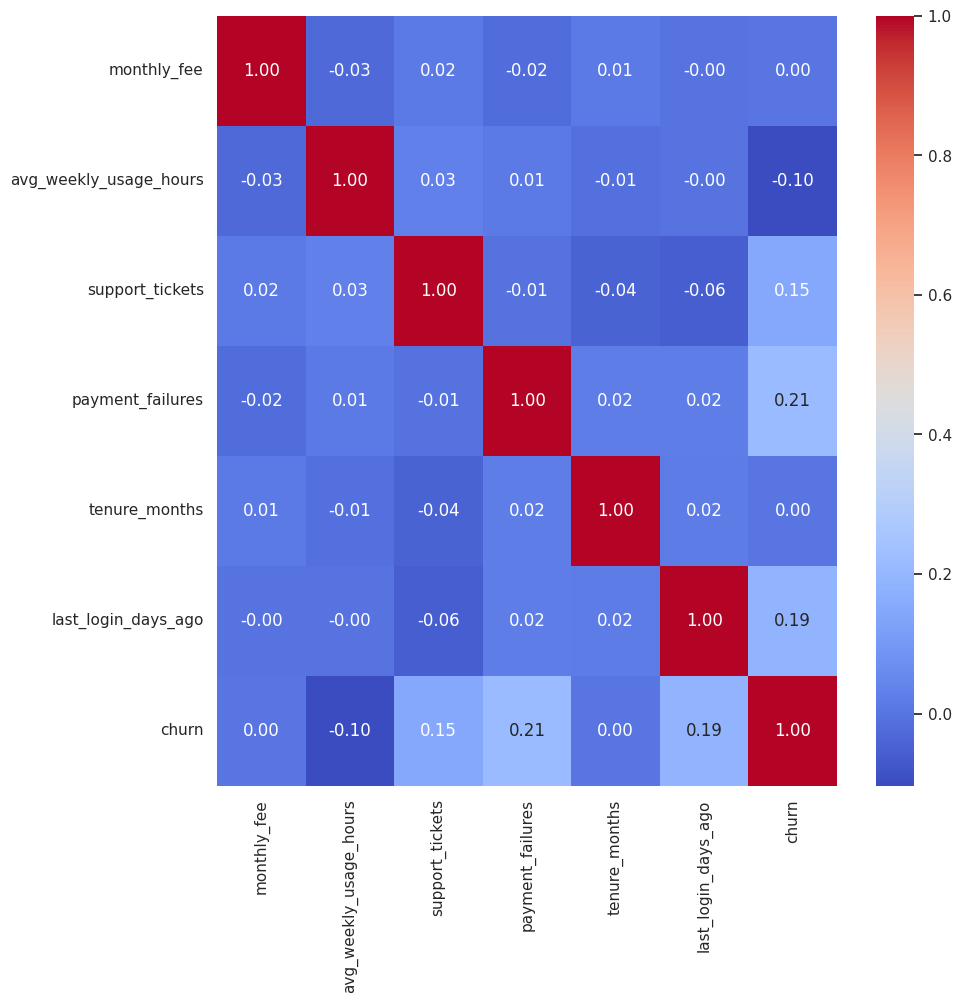

In [83]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, cmap="coolwarm",fmt=".2f")
plt.show()

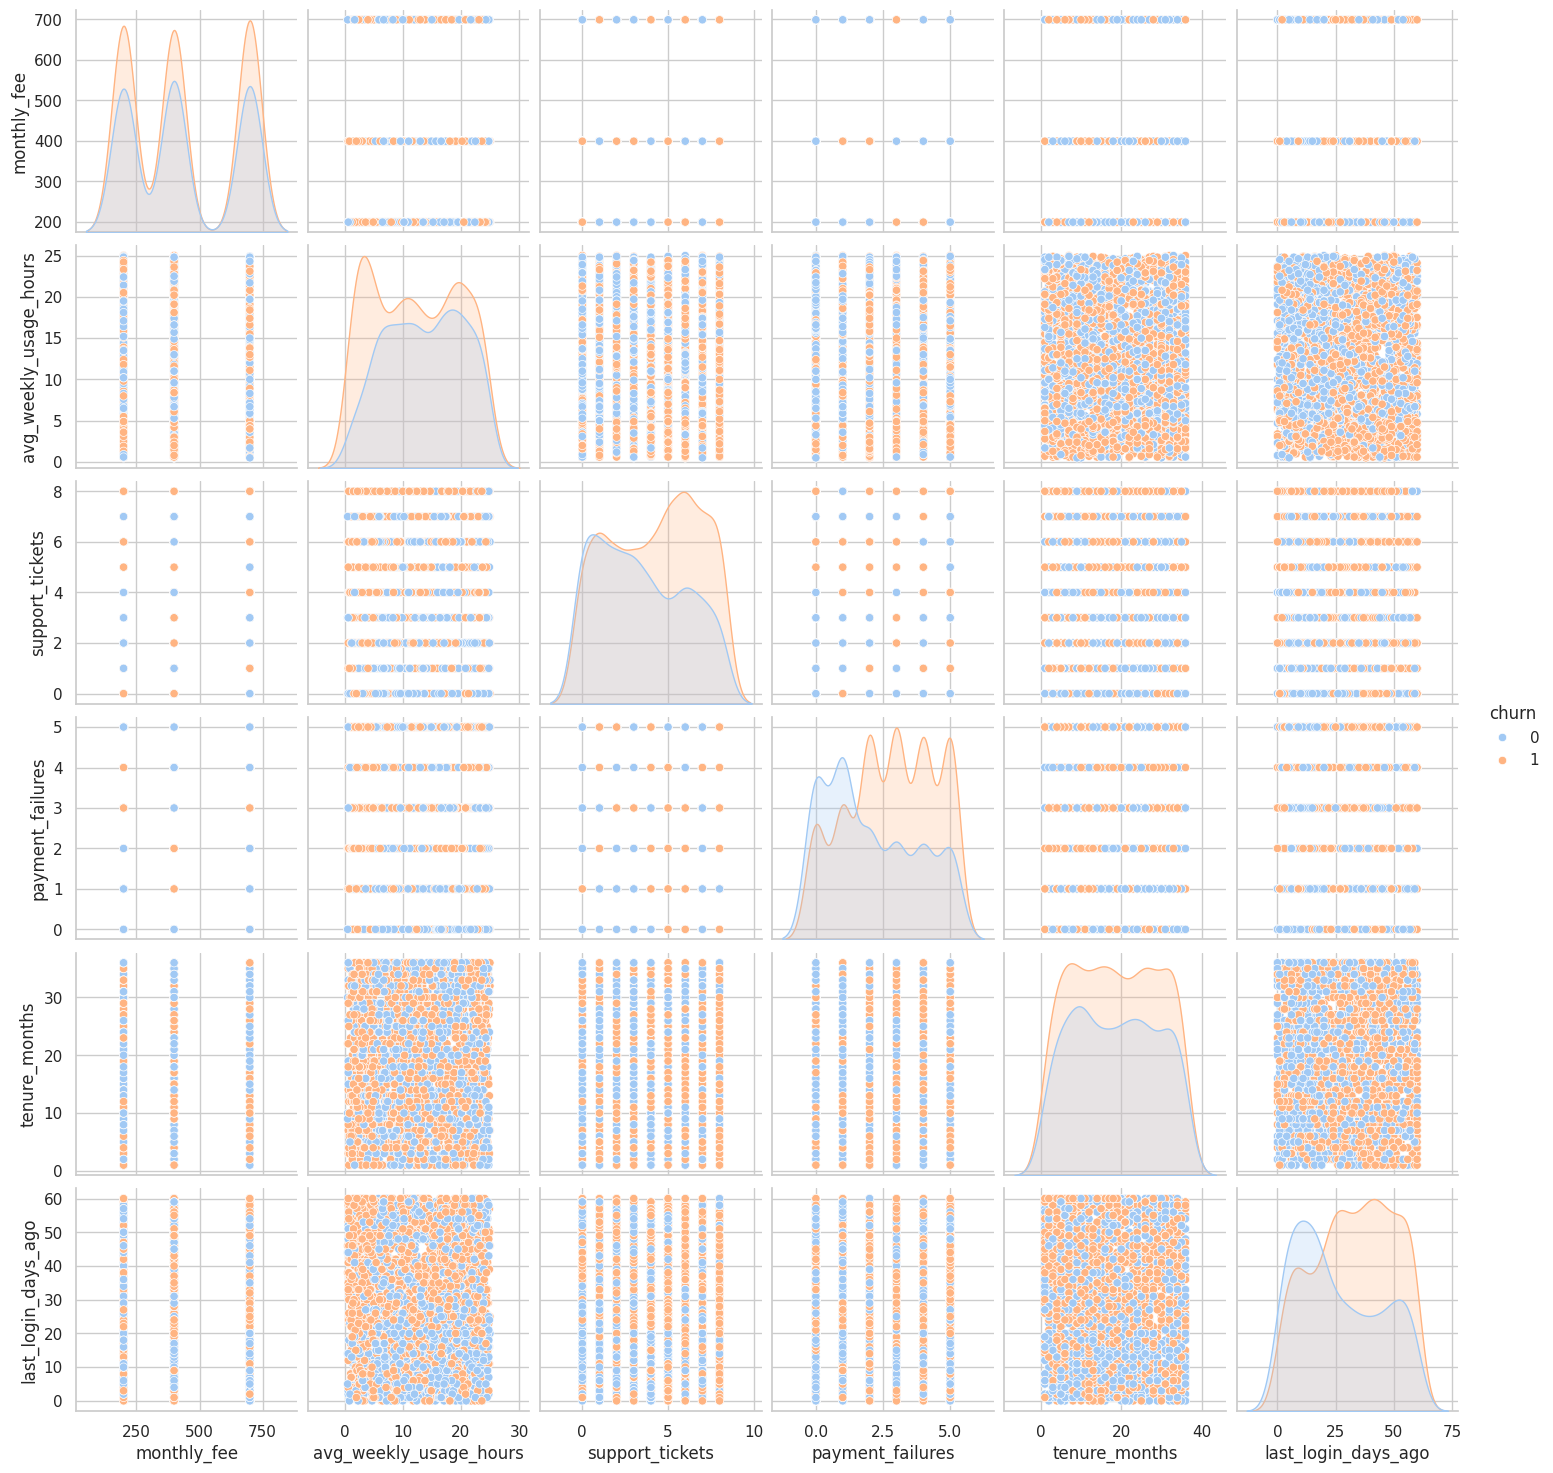

In [84]:
#pairplot
sns.pairplot(df,hue="churn")
plt.show()

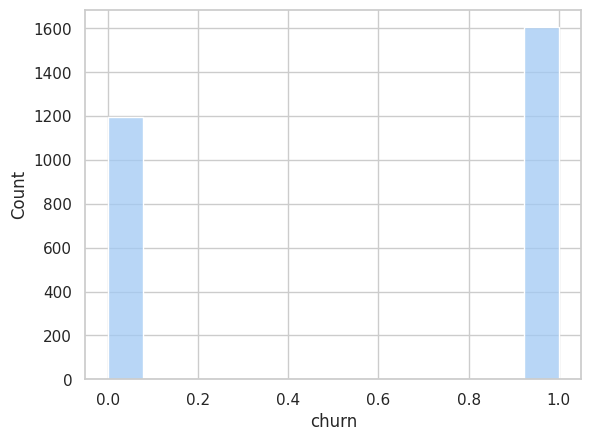

In [99]:
#churn histplot
sns.histplot(df["churn"])
plt.show()

In [85]:
#ordinal encoding of plan_type
# Define the correct order
plan_type_order = [["Basic", "Standard", "Premium"]]

# Create encoder with explicit categories
ordinalEncoder = OrdinalEncoder(categories=plan_type_order)

# Fit and transform
df["plan_type"] = ordinalEncoder.fit_transform(df[["plan_type"]]).astype(int)

In [86]:
df["account_age_days"] = (pd.Timestamp("today") - df["signup_date"]).dt.days
df = df.drop(columns=["signup_date"])

In [87]:
df["low_usage"] = (df["avg_weekly_usage_hours"] < 5).astype(int)
df["inactive_user"] = (df["last_login_days_ago"] > 30).astype(int)
df["high_support"] = (df["support_tickets"] > 5).astype(int)

In [88]:
X = df.drop("churn", axis=1)
y = df["churn"]

In [89]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [90]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
#logistic regression
lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(X_train_scaled, y_train)

lr_prediction = lr.predict(X_test_scaled)

In [92]:
#random forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

rf_prediction = rf.predict(X_test)

In [93]:
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances

avg_weekly_usage_hours    0.178488
payment_failures          0.176127
last_login_days_ago       0.173018
account_age_days          0.131319
tenure_months             0.104081
support_tickets           0.094131
low_usage                 0.050417
inactive_user             0.028805
monthly_fee               0.022042
plan_type                 0.021674
high_support              0.019898
dtype: float64

In [94]:
#model evaluation
print("Logistic Regression",accuracy_score(y_test,lr_prediction))
print("Random Forest",accuracy_score(y_test,rf_prediction))

Logistic Regression 0.6392857142857142
Random Forest 0.6678571428571428


In [96]:
#classification reports
print(classification_report(y_test,lr_prediction))

              precision    recall  f1-score   support

           0       0.57      0.66      0.61       239
           1       0.71      0.62      0.66       321

    accuracy                           0.64       560
   macro avg       0.64      0.64      0.64       560
weighted avg       0.65      0.64      0.64       560



In [97]:
print(classification_report(y_test,rf_prediction))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63       239
           1       0.73      0.67      0.70       321

    accuracy                           0.67       560
   macro avg       0.66      0.67      0.66       560
weighted avg       0.67      0.67      0.67       560

